# CELL 1: INSTALLATION & SETUP

In [ ]:
# ============================================================================
# CELL 1: INSTALLATION & SETUP
# ============================================================================

print("Installing required packages...")

# Uninstall conflicting packages
!pip uninstall -y tensorflow keras scann numpy ml-dtypes protobuf tensorboard jax jaxlib

# Install specific versions for compatibility (same as working code)
!pip install numpy==1.26.4 tensorflow==2.16.2 scann==1.3.1 keras==3.3.3 ml-dtypes==0.3.2 protobuf==4.25.8 tensorboard==2.16.2

# Uninstall jax/jaxlib again (important!)
!pip uninstall -y jax jaxlib

# Install additional dependencies
!pip install sentence-transformers scikit-learn matplotlib pillow tqdm datasets

print("\n" + "=" * 70)
print("Installation complete!")
print("=" * 70)

Installing required packages...
Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2
Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Successfully uninstalled keras-3.3.3
Found existing installation: scann 1.3.1
Uninstalling scann-1.3.1:
  Successfully uninstalled scann-1.3.1
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: ml-dtypes 0.3.2
Uninstalling ml-dtypes-0.3.2:
  Successfully uninstalled ml-dtypes-0.3.2
Found existing installation: protobuf 4.25.8
Uninstalling protobuf-4.25.8:
  Successfully uninstalled protobuf-4.25.8
Found existing installation: tensorboard 2.16.2
Uninstalling tensorboard-2.16.2:
  Successfully uninstalled tensorboard-2.16.2
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached tensorflow-2.16.2-cp312-cp312-manylinux_2


Installation complete!


# CELL 2: COMPLETE INPUT COLLECTION

INPUT COLLECTION

What would you like to search for?
  1. Upload an image to find similar images
  2. Enter text to find similar documents

Enter your choice (1 or 2): 1

Please upload your query image:


Saving Lương Hoàng Vĩnh Tiến_2413477.jpg to Lương Hoàng Vĩnh Tiến_2413477.jpg

Detected: IMAGE SEARCH


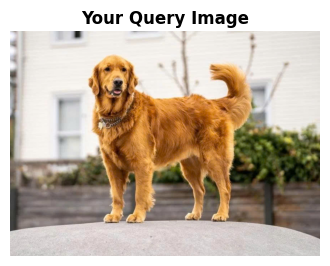


How many similar results do you want to find (K): 500

INPUT COMPLETE!
  Search type: IMAGE
  K value: 500
Starting automatic dataset loading and search...


18126

In [ ]:
# ============================================================================
# CELL 2: COMPLETE INPUT COLLECTION
# ============================================================================

import gc
import numpy as np
import matplotlib.pyplot as plt

print("=" * 70)
print("INPUT COLLECTION")
print("=" * 70)

# Step 1: Get query type and content
print("\nWhat would you like to search for?")
print("  1. Upload an image to find similar images")
print("  2. Enter text to find similar documents")

query_mode = input("\nEnter your choice (1 or 2): ").strip()

if query_mode == "1":
    # IMAGE QUERY
    print("\nPlease upload your query image:")
    from google.colab import files
    uploaded = files.upload()
    query_image_path = list(uploaded.keys())[0]

    SEARCH_TYPE = "image"
    print("\nDetected: IMAGE SEARCH")

    # Display query image immediately
    from PIL import Image
    query_img = Image.open(query_image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(query_img)
    plt.title("Your Query Image", fontweight='bold', fontsize=12)
    plt.axis('off')
    plt.show()

elif query_mode == "2":
    # TEXT QUERY
    query_text = input("\nEnter your search query: ").strip()

    if not query_text:
        raise ValueError("Query text cannot be empty!")

    SEARCH_TYPE = "text"
    print("\nDetected: TEXT SEARCH")
    print(f'Query: "{query_text}"')

else:
    raise ValueError("Invalid choice! Please enter 1 or 2.")

# Step 2: Get K value
K = int(input("\nHow many similar results do you want to find (K): "))
if K <= 0 or K > 10000:
    raise ValueError(f"K must be between 1 and 10000")

print("\n" + "=" * 70)
print(f"INPUT COMPLETE!")
print(f"  Search type: {SEARCH_TYPE.upper()}")
print(f"  K value: {K}")
print(f"Starting automatic dataset loading and search...")
print("=" * 70)

gc.collect()

# CELL 3: STREAMING PIPELINE (Load + Extract Features)

STREAMING PIPELINE: LOAD & EXTRACT FEATURES (IMAGE)

[Init] Setting up ResNet50 Pipeline...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

[Processing] Loading ImageNet-Sketch (Streaming)...


README.md: 0.00B [00:00, ?B/s]

Processing images: 100%|██████████| 5000/5000 [13:13<00:00,  6.30it/s]



[Query] Extracting query image features...

PIPELINE COMPLETE
Dataset size: 5,000
Features shape: (5000, 2048)
Query shape: (1, 2048)
Memory: ~39.1 MB

Displaying sample images:


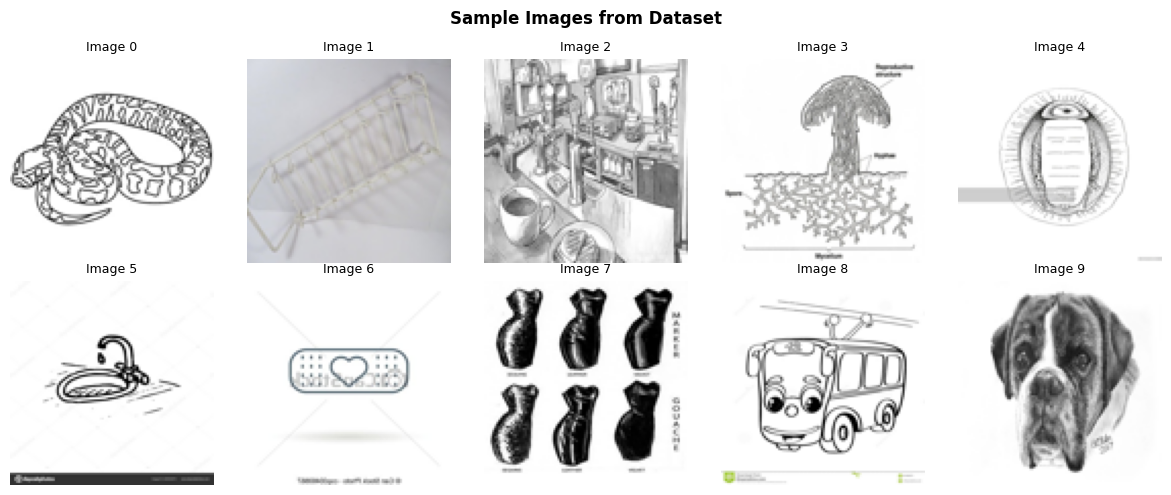

In [ ]:
# ============================================================================
# CELL 3: STREAMING PIPELINE (Load + Extract Features)
# ============================================================================

import numpy as np
import gc
import tensorflow as tf
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from PIL import Image

print("=" * 70)
print(f"STREAMING PIPELINE: LOAD & EXTRACT FEATURES ({SEARCH_TYPE.upper()})")
print("=" * 70)

# Storage for visualization (RAM efficient thumbnails)
dataset_visuals = []
feature_vectors = []

# Configuration
MAX_SAMPLES = 5000
BATCH_SIZE = 128

if SEARCH_TYPE == "image":
    print("\n[Init] Setting up ResNet50 Pipeline...")
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input

    # Load Model
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Batch processing function
    def process_batch(images):
        processed_imgs = []
        for img in images:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_model = img.resize((224, 224), Image.Resampling.LANCZOS)
            processed_imgs.append(keras_image.img_to_array(img_model))
        return preprocess_input(np.array(processed_imgs))

    print(f"\n[Processing] Loading ImageNet-Sketch (Streaming)...")
    dataset = load_dataset("vaughankraska/imagenet_sketch", split="train", streaming=True)

    batch_images = []
    pbar = tqdm(total=MAX_SAMPLES, desc="Processing images")
    count = 0

    for item in dataset:
        if count >= MAX_SAMPLES:
            break

        img = item['image']
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Store thumbnail (100x100 for visualization)
        img_thumb = img.resize((100, 100))
        dataset_visuals.append(np.array(img_thumb, dtype=np.uint8))

        # Accumulate for batch processing
        batch_images.append(img)
        count += 1

        # Process batch and extract features
        if len(batch_images) == BATCH_SIZE:
            batch_input = process_batch(batch_images)
            batch_features = model.predict(batch_input, verbose=0)
            feature_vectors.append(batch_features)

            batch_images = []
            gc.collect()
            pbar.update(BATCH_SIZE)

    # Process final batch
    if batch_images:
        batch_input = process_batch(batch_images)
        batch_features = model.predict(batch_input, verbose=0)
        feature_vectors.append(batch_features)
        pbar.update(len(batch_images))

    pbar.close()

    # Concatenate feature arrays
    feature_vectors = np.vstack(feature_vectors)

    # Extract Query Image
    print("\n[Query] Extracting query image features...")
    q_img = keras_image.load_img(query_image_path, target_size=(224, 224))
    q_arr = np.expand_dims(keras_image.img_to_array(q_img), axis=0)
    q_arr = preprocess_input(q_arr)
    query_vector = model.predict(q_arr, verbose=0)

    del model
    tf.keras.backend.clear_session()

elif SEARCH_TYPE == "text":
    print(f"\n[Processing] Loading MS MARCO Dataset...")
    from sentence_transformers import SentenceTransformer

    device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

    # Load MS MARCO with proper authentication
    print("Loading MS MARCO v2.1 passages...")

    # Sử dụng HF_TOKEN nếu cần
    try:
        dataset = load_dataset(
            "ms_marco",
            "v2.1",
            split="train",
            streaming=True,
            use_auth_token=True  # Tự động dùng HF_TOKEN từ environment
        )
    except:
        # Nếu không cần token
        dataset = load_dataset("ms_marco", "v2.1", split="train", streaming=True)

    all_texts = []
    seen_texts = set()  # Để loại bỏ duplicate
    seen_hashes = set()  # Hash để kiểm tra nhanh

    count = 0
    skip_count = 0

    print(f"Sampling {MAX_SAMPLES} unique passages...")
    pbar = tqdm(total=MAX_SAMPLES, desc="Loading unique texts")

    for item in dataset:
        if count >= MAX_SAMPLES:
            break

        text = None

        # Thử nhiều cách extract text từ MS MARCO structure
        if 'passages' in item and 'passage_text' in item['passages']:
            passages = item['passages']['passage_text']
            if passages and len(passages) > 0:
                text = passages[0]

        elif 'passage' in item:
            text = item['passage']

        elif 'text' in item:
            text = item['text']

        # Kiểm tra và thêm text
        if text and len(text.strip()) > 50:
            text = text.strip()

            # Tạo hash để kiểm tra duplicate nhanh
            text_hash = hash(text[:150])  # Hash 150 ký tự đầu

            # Kiểm tra duplicate
            if text_hash not in seen_hashes:
                # Double check với full text (cho chắc)
                if text not in seen_texts:
                    all_texts.append(text)
                    seen_texts.add(text)
                    seen_hashes.add(text_hash)
                    count += 1
                    pbar.update(1)
                else:
                    skip_count += 1
            else:
                skip_count += 1

    pbar.close()

    print(f"\nSuccessfully loaded {len(all_texts)} unique MS MARCO passages")
    print(f"Skipped {skip_count} duplicate passages")

    # Store text for visualization
    dataset_visuals = all_texts

    # Encode documents
    print(f"\nEncoding {len(all_texts)} documents...")
    feature_vectors = model.encode(
        all_texts,
        batch_size=256,
        show_progress_bar=True,
        convert_to_numpy=True
    )

    # Encode query
    print("Encoding query...")
    query_vector = model.encode([query_text], convert_to_numpy=True)

    del model
    del seen_texts  # Free memory
    del seen_hashes

gc.collect()

print(f"\n" + "=" * 70)
print("PIPELINE COMPLETE")
print("=" * 70)
print(f"Dataset size: {len(dataset_visuals):,}")
print(f"Features shape: {feature_vectors.shape}")
print(f"Query shape: {query_vector.shape}")
print(f"Memory: ~{feature_vectors.nbytes / (1024**2):.1f} MB")

# Display sample
if SEARCH_TYPE == "text":
    print("\nSample unique passages:")
    for i in range(min(5, len(dataset_visuals))):
        print(f"\n{i+1}. [{len(dataset_visuals[i])} chars] {dataset_visuals[i][:200]}...")
else:
    print("\nDisplaying sample images:")
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(dataset_visuals[i])
        ax.axis('off')
        ax.set_title(f"Image {i}", fontsize=9)
    plt.suptitle("Sample Images from Dataset", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# CELL 4: LINEAR SEARCH BASELINE

In [ ]:
# ============================================================================
# CELL 4: LINEAR SEARCH BASELINE
# ============================================================================

import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil
import pandas as pd
from datetime import datetime

print("=" * 70)
print("LINEAR SEARCH (Brute-Force Baseline)")
print("=" * 70)

print(f"\nSearching through {len(feature_vectors):,} vectors...")
start_time = time.time()
similarities = cosine_similarity(query_vector, feature_vectors)[0]
linear_indices = np.argsort(-similarities)[:K]
linear_time = time.time() - start_time

print(f"Search completed in {linear_time*1000:.2f} ms")

# Display results
print(f"\nTop-{K} results from Linear Search:")

if SEARCH_TYPE == "image":
    cols = 5
    rows = ceil(K / cols)
    fig = plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for i, idx in enumerate(linear_indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(dataset_visuals[idx])
        plt.title(f"Rank {i+1}\nSim={similarities[idx]:.3f}", fontsize=9)
        plt.axis('off')

    plt.suptitle(f"Linear Search: Top-{K} Similar Images",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Export image results to CSV
    print("\nExporting image results to CSV...")
    results_data = []
    for i, idx in enumerate(linear_indices):
        results_data.append({
            'Rank': i + 1,
            'Dataset_Index': int(idx),
            'Similarity_Score': float(similarities[idx]),
            'Image_Shape': f"{dataset_visuals[idx].shape}",
            'Method': 'Linear_Search'
        })

else:
    # Show top 10 in console
    print("\n--- TOP 10 RESULTS ---")
    for i, idx in enumerate(linear_indices[:10]):
        print(f"\n{i+1}. Similarity: {similarities[idx]:.4f}")
        print(f"   {dataset_visuals[idx][:150]}...")

    if K > 10:
        print(f"\n... ({K - 10} more results - see CSV file)")

    # Export text results to CSV
    print("\nExporting text results to CSV...")
    results_data = []
    for i, idx in enumerate(linear_indices):
        results_data.append({
            'Rank': i + 1,
            'Dataset_Index': int(idx),
            'Similarity_Score': float(similarities[idx]),
            'Text_Length': len(dataset_visuals[idx]),
            'Text_Preview': dataset_visuals[idx][:200],
            'Full_Text': dataset_visuals[idx],
            'Method': 'Linear_Search'
        })

# Create DataFrame and export
df = pd.DataFrame(results_data)
csv_file = f"linear_search_{SEARCH_TYPE}_{K}results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(csv_file, index=False, encoding='utf-8')

print(f"   Results exported to: {csv_file}")
print(f"   Total results: {K}")
print(f"   File size: ~{len(df) * 100 / 1024:.1f} KB")

# Store baseline
linear_baseline = {
    'indices': linear_indices,
    'time': linear_time,
    'similarities': similarities[linear_indices]
}

print("\n" + "=" * 70)
print(f"BASELINE: {linear_time*1000:.2f} ms | 100% accuracy")
print("=" * 70)

gc.collect()

LINEAR SEARCH (Brute-Force Baseline)

Searching through 5,000 vectors...
Search completed in 52.88 ms

Top-500 results from Linear Search:


# CELL 5: BUILD AND TEST ScaNN MODELS

In [ ]:

# ============================================================================
# CELL 5: BUILD ScaNN MODELS (NO SEARCHING YET)
# ============================================================================

import scann
import numpy as np
import time

print("=" * 70)
print("BUILDING ScaNN MODELS")
print("=" * 70)

# Normalize vectors
print("\nNormalizing vectors for dot product similarity...")
feature_vectors_norm = feature_vectors / np.linalg.norm(feature_vectors, axis=1, keepdims=True)
query_vector_norm = query_vector / np.linalg.norm(query_vector, axis=1, keepdims=True)

# ScaNN configurations
scann_configs = [
    {
        'name': 'ScaNN-Fast',
        'description': 'Fastest search, lower accuracy',
        'num_leaves': 100,
        'num_leaves_to_search': 10,
        'reordering': 0
    },
    {
        'name': 'ScaNN-Balanced',
        'description': 'Balanced speed and accuracy',
        'num_leaves': 200,
        'num_leaves_to_search': 20,
        'reordering': int(K * 2)
    },
    {
        'name': 'ScaNN-Accurate',
        'description': 'Higher accuracy, slower',
        'num_leaves': 400,
        'num_leaves_to_search': 40,
        'reordering': int(K * 5)
    },
    {
        'name': 'ScaNN-Precision',
        'description': 'Maximum accuracy',
        'num_leaves': 600,
        'num_leaves_to_search': 60,
        'reordering': int(K * 10)
    }
]

# Build models ONLY (no searching)
scann_models = {}

for i, config in enumerate(scann_configs):
    print(f"\n[{i+1}/4] Building {config['name']}...")
    print(f"    {config['description']}")

    # Build index
    builder = scann.scann_ops_pybind.builder(
        feature_vectors_norm, K, "dot_product"
    ).tree(
        num_leaves=config['num_leaves'],
        num_leaves_to_search=config['num_leaves_to_search'],
        training_sample_size=min(len(feature_vectors_norm), 10000)
    )

    if config['reordering'] > 0:
        builder = builder.score_ah(2, anisotropic_quantization_threshold=0.2)
        searcher = builder.reorder(config['reordering']).build()
    else:
        searcher = builder.score_brute_force().build()

    # Store model
    scann_models[config['name']] = {
        'searcher': searcher,
        'config': config
    }

    print(f"    Built successfully")

print("\n" + "=" * 70)
print("All 4 ScaNN models built!")
print("=" * 70)

gc.collect()

BUILDING ScaNN MODELS

Normalizing vectors for dot product similarity...

[1/4] Building ScaNN-Fast...
    Fastest search, lower accuracy
    Built successfully

[2/4] Building ScaNN-Balanced...
    Balanced speed and accuracy
    Built successfully

[3/4] Building ScaNN-Accurate...
    Higher accuracy, slower
    Built successfully

[4/4] Building ScaNN-Precision...
    Maximum accuracy
    Built successfully

All 4 ScaNN models built!


28

# CELL 6: K-VALUE ANALYSIS


In [ ]:
# ============================================================================
# CELL 6: K-VALUE ANALYSIS
# ============================================================================

import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity

print("=" * 70)
print("ANALYZING PERFORMANCE ACROSS K VALUES")
print("=" * 70)

# Smart K value selection using geometric progression (base 2)
def generate_smart_k_values(user_k, max_k):
    """
    Generate K values as geometric progression with ratio 2
    STOPS when reaching user_k, then adds user_k

    Example:
      user_k=500 -> [1, 2, 4, 8, 16, 32, 64, 128, 256, 500]
      user_k=100 -> [1, 2, 4, 8, 16, 32, 64, 100]
      user_k=50  -> [1, 2, 4, 8, 16, 32, 50]
    """
    k_values = []
    current = 1

    while current < user_k:
        k_values.append(current)
        current *= 2

    k_values.append(user_k)
    return k_values

k_values = generate_smart_k_values(K, len(feature_vectors))

print(f"\nUser selected K: {K}")
print(f"Testing K values: {k_values}")
print(f"Total tests: {len(k_values)} K values x 5 methods = {len(k_values) * 5} searches")
print(f"Estimated time: ~{len(k_values) * 5 * 0.05:.0f} seconds")

# Storage
perf_data = {
    'k_values': k_values,
    'linear': {'times': [], 'recalls': []},
}

for config in scann_configs:
    perf_data[config['name']] = {'times': [], 'recalls': []}

# ALSO store results at user's K for later use
scann_results = []

# Test each K
from tqdm import tqdm
print("\n" + "-" * 70)

for k_idx, k in enumerate(tqdm(k_values, desc="Testing K values")):
    # Linear search
    start = time.time()
    sims = cosine_similarity(query_vector, feature_vectors)[0]
    linear_idx_k = np.argsort(-sims)[:k]
    linear_t = time.time() - start

    perf_data['linear']['times'].append(linear_t * 1000)
    perf_data['linear']['recalls'].append(100.0)

    # ScaNN models
    for config in scann_configs:
        model_name = config['name']
        searcher = scann_models[model_name]['searcher']

        start = time.time()
        neighbors, distances = searcher.search_batched(query_vector_norm, final_num_neighbors=k)
        scann_t = time.time() - start

        # Calculate recall
        found = set(neighbors[0])
        gt = set(linear_idx_k)
        recall = len(found & gt) / k * 100

        perf_data[model_name]['times'].append(scann_t * 1000)
        perf_data[model_name]['recalls'].append(recall)

        # Store results at user's K for visualization
        if k == K:
            result = {
                'name': model_name,
                'indices': neighbors[0],
                'distances': distances[0],
                'time': scann_t,
                'recall': recall / 100,  # Convert to 0-1 range
                'speedup': linear_t / scann_t
            }
            scann_results.append(result)

print("\n" + "=" * 70)
print("K-VALUE ANALYSIS COMPLETE")
print("=" * 70)

# Summary table
print(f"\n{'K Value':<10} {'Linear (ms)':<15} {'Best ScaNN':<20} {'Speedup':<10}")
print("-" * 70)

for i, k in enumerate(k_values):
    linear_time = perf_data['linear']['times'][i]

    # Find best ScaNN time
    scann_times = [perf_data[name]['times'][i] for name in [c['name'] for c in scann_configs]]
    best_scann_time = min(scann_times)
    best_scann_name = [c['name'] for c in scann_configs
                       if perf_data[c['name']]['times'][i] == best_scann_time][0]

    speedup = linear_time / best_scann_time
    marker = " <-" if k == K else ""

    print(f"{k:<10} {linear_time:<15.2f} {best_scann_name:<20} {speedup:<10.1f}x{marker}")

print("=" * 70)

# CONSISTENCY CHECK
print("\n" + "=" * 70)
print("RESULTS AT USER'S K")
print("=" * 70)
print(f"{'Config':<20} {'Time (ms)':<12} {'Recall':<12} {'Speedup':<10}")
print("-" * 70)

k_idx = k_values.index(K)
print(f"{'Linear Search':<20} {perf_data['linear']['times'][k_idx]:<12.2f} {'100.0%':<12} {'1.00x':<10}")

for res in scann_results:
    print(f"{res['name']:<20} {res['time']*1000:<12.2f} {res['recall']*100:<11.1f}% {res['speedup']:<10.2f}x")

print("=" * 70)

gc.collect()

ANALYZING PERFORMANCE ACROSS K VALUES

User selected K: 500
Testing K values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 500]
Total tests: 10 K values x 5 methods = 50 searches
Estimated time: ~2 seconds

----------------------------------------------------------------------


Testing K values: 100%|██████████| 10/10 [00:00<00:00, 137.42it/s]


K-VALUE ANALYSIS COMPLETE

K Value    Linear (ms)     Best ScaNN           Speedup   
----------------------------------------------------------------------
1          6.42            ScaNN-Fast           37.8      x
2          6.02            ScaNN-Fast           37.7      x
4          5.70            ScaNN-Fast           36.5      x
8          5.45            ScaNN-Fast           41.2      x
16         5.74            ScaNN-Fast           40.0      x
32         5.70            ScaNN-Fast           39.3      x
64         5.40            ScaNN-Fast           37.3      x
128        5.78            ScaNN-Fast           33.4      x
256        5.54            ScaNN-Fast           31.4      x
500        5.53            ScaNN-Fast           28.1      x <-

RESULTS AT USER'S K
Config               Time (ms)    Recall       Speedup   
----------------------------------------------------------------------
Linear Search        5.53         100.0%       1.00x     
ScaNN-Fast           0.20      

0

# CELL 7: VISUALIZE ScaNN RESULTS

In [ ]:
# ============================================================================
# CELL 7: VISUALIZE ScaNN RESULTS
# ============================================================================

import matplotlib.pyplot as plt
from math import ceil
import pandas as pd
from datetime import datetime

print("=" * 70)
print("ScaNN RESULTS VISUALIZATION")
print("=" * 70)

# Select configuration
print("\nAvailable configurations:")
for i, res in enumerate(scann_results):
    print(f"  {i+1}. {res['name']} - Recall: {res['recall']*100:.1f}%, Time: {res['time']*1000:.2f}ms, Speedup: {res['speedup']:.2f}x")

config_choice = int(input(f"\nSelect config to visualize (1-{len(scann_results)}): ")) - 1
selected = scann_results[config_choice]

print(f"\nShowing results from: {selected['name']}")
print(f"  Recall: {selected['recall']*100:.1f}%")
print(f"  Time: {selected['time']*1000:.2f}ms")
print(f"  Speedup: {selected['speedup']:.2f}x")

# Display results
if SEARCH_TYPE == "image":
    cols = 5
    rows = ceil(K / cols)
    plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for i, idx in enumerate(selected['indices']):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(dataset_visuals[idx])

        # Mark correct/incorrect
        is_correct = idx in linear_baseline['indices']
        color = 'green' if is_correct else 'red'

        # Handle NaN distances (use cosine similarity instead)
        if np.isnan(selected['distances'][i]):
            score = np.dot(query_vector_norm[0], feature_vectors_norm[idx])
        else:
            score = selected['distances'][i]

        plt.title(f"#{i+1}\nScore={score:.3f}",
                  fontsize=9, color=color)
        plt.axis('off')

        # Border
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.suptitle(f"{selected['name']}: Top-{K} Results\n" +
                 f"Recall: {selected['recall']*100:.1f}% | Time: {selected['time']*1000:.2f}ms | Speedup: {selected['speedup']:.2f}x",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Export image results
    print("\nExporting ScaNN image results to CSV...")
    results_data = []
    for i, idx in enumerate(selected['indices']):
        is_correct = idx in linear_baseline['indices']

        if np.isnan(selected['distances'][i]):
            score = np.dot(query_vector_norm[0], feature_vectors_norm[idx])
        else:
            score = selected['distances'][i]

        # Find rank in linear search (if exists)
        linear_rank = np.where(linear_baseline['indices'] == idx)[0]
        linear_rank = int(linear_rank[0] + 1) if len(linear_rank) > 0 else None

        results_data.append({
            'ScaNN_Rank': i + 1,
            'Dataset_Index': int(idx),
            'Score': float(score),
            'Is_Correct': is_correct,
            'Linear_Rank': linear_rank,
            'Rank_Difference': abs(i + 1 - linear_rank) if linear_rank else None,
            'Image_Shape': f"{dataset_visuals[idx].shape}",
            'Method': selected['name']
        })

else:
    # Show top 10 in console
    print(f"\nTop-10 results (out of {K}):")
    for i, idx in enumerate(selected['indices'][:10]):
        is_correct = idx in linear_baseline['indices']
        marker = "CORRECT" if is_correct else "INCORRECT"

        # Handle NaN distances
        if np.isnan(selected['distances'][i]):
            score = np.dot(query_vector_norm[0], feature_vectors_norm[idx])
        else:
            score = selected['distances'][i]

        print(f"\n{marker} - Rank {i+1} | Score: {score:.4f}")
        print(f"   {dataset_visuals[idx][:150]}...")

    if K > 10:
        print(f"\n... ({K - 10} more results - see CSV file)")

    # Export text results
    print("\nExporting ScaNN text results to CSV...")
    results_data = []
    for i, idx in enumerate(selected['indices']):
        is_correct = idx in linear_baseline['indices']

        if np.isnan(selected['distances'][i]):
            score = np.dot(query_vector_norm[0], feature_vectors_norm[idx])
        else:
            score = selected['distances'][i]

        # Find rank in linear search
        linear_rank = np.where(linear_baseline['indices'] == idx)[0]
        linear_rank = int(linear_rank[0] + 1) if len(linear_rank) > 0 else None

        results_data.append({
            'ScaNN_Rank': i + 1,
            'Dataset_Index': int(idx),
            'Score': float(score),
            'Is_Correct': is_correct,
            'Linear_Rank': linear_rank,
            'Rank_Difference': abs(i + 1 - linear_rank) if linear_rank else None,
            'Text_Length': len(dataset_visuals[idx]),
            'Text_Preview': dataset_visuals[idx][:200],
            'Full_Text': dataset_visuals[idx],
            'Method': selected['name']
        })

# Create DataFrame and export
df = pd.DataFrame(results_data)
csv_file = f"scann_{selected['name']}_{SEARCH_TYPE}_{K}results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(csv_file, index=False, encoding='utf-8')

# Calculate statistics
correct_count = df['Is_Correct'].sum()
recall_pct = (correct_count / K) * 100

print(f"\n Results exported to: {csv_file}")
print(f"   Total results: {K}")
print(f"   Correct matches: {correct_count} ({recall_pct:.1f}%)")
print(f"   File size: ~{len(df) * 150 / 1024:.1f} KB")

print("\n" + "=" * 70)

ScaNN RESULTS VISUALIZATION

Available configurations:
  1. ScaNN-Fast - Recall: 40.6%, Time: 0.20ms, Speedup: 28.13x
  2. ScaNN-Balanced - Recall: 46.2%, Time: 0.34ms, Speedup: 16.09x
  3. ScaNN-Accurate - Recall: 42.2%, Time: 0.31ms, Speedup: 17.61x
  4. ScaNN-Precision - Recall: 52.2%, Time: 0.44ms, Speedup: 12.51x

Select config to visualize (1-4): 4

Showing results from: ScaNN-Precision
  Recall: 52.2%
  Time: 0.44ms
  Speedup: 12.51x

Top-10 results (out of 500):

CORRECT - Rank 1 | Score: 0.6489
   Yesterday's weather. Scattered clouds. 46 / 61 °F Humidity: 51%. Wind: 12 mph ↑ from West. More weather last week...

CORRECT - Rank 2 | Score: 0.6290
   Local Weather. Today's Weather; Hourly Forecast; Extended; Weekend; Month Outlook; Current Weather...

CORRECT - Rank 3 | Score: 0.5053
   A mix of sun and cloud. 30 percent chance of showers in the afternoon with risk of a thunderstorm. Wind southwest 30 km/h gusting to 50....

CORRECT - Rank 4 | Score: 0.4944
   Latest weather rad

# CELL 8: PERFORMANCE VISUALIZATION

GENERATING PERFORMANCE VISUALIZATIONS


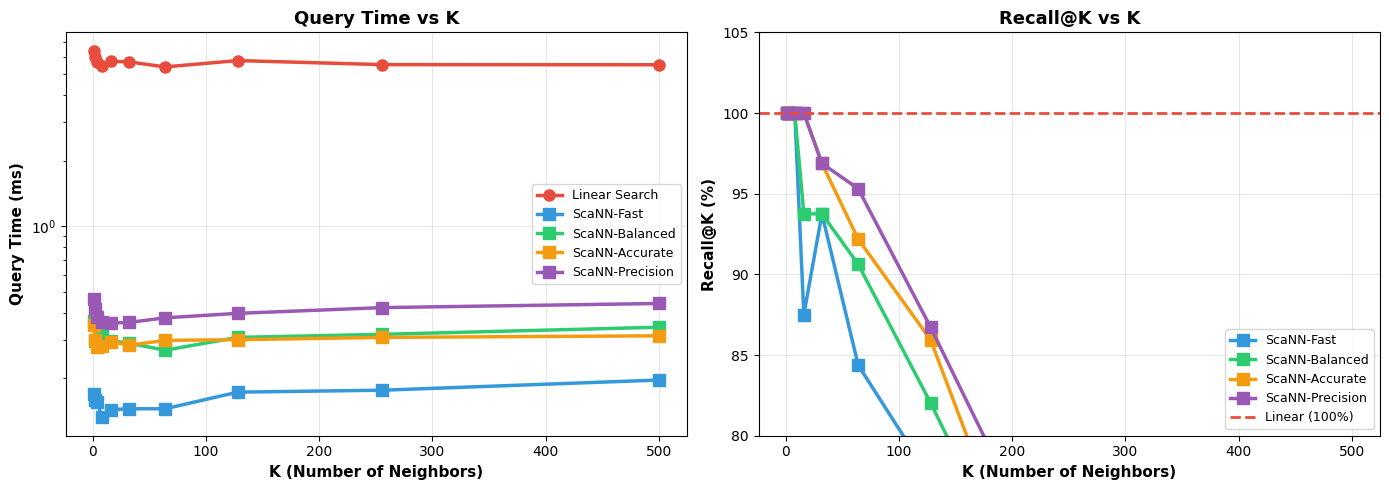

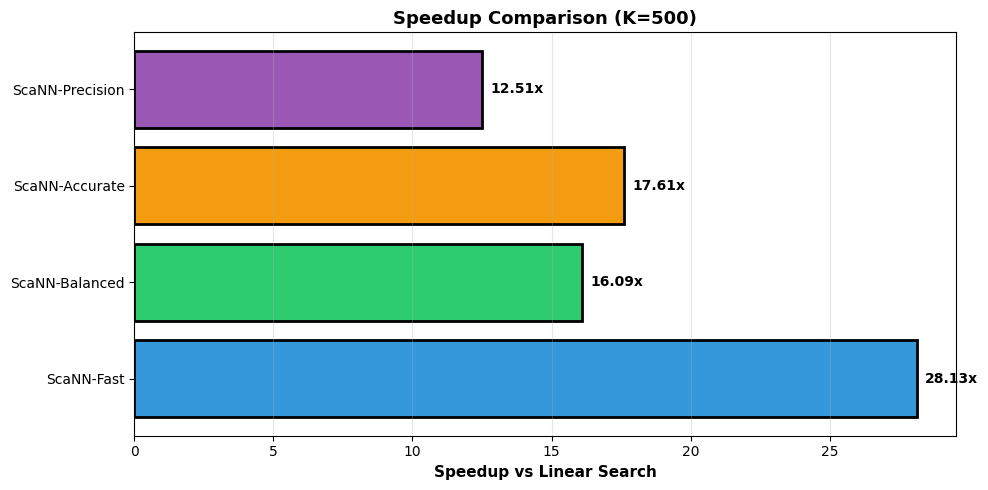


Visualizations complete!


In [ ]:
# ============================================================================
# CELL 8: PERFORMANCE VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("=" * 70)
print("GENERATING PERFORMANCE VISUALIZATIONS")
print("=" * 70)

colors = {
    'Linear Search (Exact)': '#e74c3c',
    'ScaNN-Fast': '#3498db',
    'ScaNN-Balanced': '#2ecc71',
    'ScaNN-Accurate': '#f39c12',
    'ScaNN-Precision': '#9b59b6'
}

# Figure 1: Time and Recall vs K
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Query Time vs K
ax1.plot(perf_data['k_values'], perf_data['linear']['times'],
         marker='o', linewidth=2.5, markersize=8,
         label='Linear Search', color=colors['Linear Search (Exact)'])

for config in scann_configs:
    ax1.plot(perf_data['k_values'], perf_data[config['name']]['times'],
             marker='s', linewidth=2.5, markersize=8,
             label=config['name'], color=colors[config['name']])

ax1.set_xlabel('K (Number of Neighbors)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Query Time (ms)', fontsize=11, fontweight='bold')
ax1.set_title('Query Time vs K', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Recall vs K
for config in scann_configs:
    ax2.plot(perf_data['k_values'], perf_data[config['name']]['recalls'],
             marker='s', linewidth=2.5, markersize=8,
             label=config['name'], color=colors[config['name']])

ax2.axhline(y=100, color=colors['Linear Search (Exact)'],
            linestyle='--', linewidth=2, label='Linear (100%)')
ax2.set_xlabel('K (Number of Neighbors)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Recall@K (%)', fontsize=11, fontweight='bold')
ax2.set_title('Recall@K vs K', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([80, 105])

plt.tight_layout()
plt.show()

# Figure 2: Speedup Comparison
fig, ax = plt.subplots(figsize=(10, 5))

k_idx = perf_data['k_values'].index(K)
linear_t = perf_data['linear']['times'][k_idx]

speedups = []
names = []
bar_colors = []

for config in scann_configs:
    scann_t = perf_data[config['name']]['times'][k_idx]
    speedups.append(linear_t / scann_t)
    names.append(config['name'])
    bar_colors.append(colors[config['name']])

bars = ax.barh(names, speedups, color=bar_colors, edgecolor='black', linewidth=2)

for bar, speedup in zip(bars, speedups):
    width = bar.get_width()
    ax.text(width + 0.3, bar.get_y() + bar.get_height()/2,
            f'{speedup:.2f}x', ha='left', va='center',
            fontsize=10, fontweight='bold')

ax.set_xlabel('Speedup vs Linear Search', fontsize=11, fontweight='bold')
ax.set_title(f'Speedup Comparison (K={K})',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")
print("=" * 70)

# CELL 9: SUMMARY AND EXPORT

In [ ]:
# ============================================================================
# CELL 9: SUMMARY AND EXPORT
# ============================================================================

import numpy as np
import pandas as pd
from datetime import datetime

print("=" * 70)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 70)

# Statistics table
print("\n" + "=" * 80)
print(f"{'Configuration':<20} {'Avg Time':<12} {'Min Recall':<12} {'Max Speedup':<12}")
print("=" * 80)

linear_avg = np.mean(perf_data['linear']['times'])
print(f"{'Linear Search':<20} {linear_avg:<12.2f} {'100.0%':<12} {'1.00x':<12}")

for config in scann_configs:
    times = perf_data[config['name']]['times']
    recalls = perf_data[config['name']]['recalls']

    avg_time = np.mean(times)
    min_recall = np.min(recalls)
    max_speedup = np.max([linear_avg / t for t in times])

    print(f"{config['name']:<20} {avg_time:<12.2f} {min_recall:<11.1f}% {max_speedup:<12.2f}x")

print("=" * 80)

# Key insights
print("\nKEY INSIGHTS:")
print("-" * 70)

best_speed = min(scann_configs, key=lambda c: np.mean(perf_data[c['name']]['times']))
best_speedup = linear_avg / np.mean(perf_data[best_speed['name']]['times'])
print(f"1. FASTEST: {best_speed['name']} achieves {best_speedup:.2f}x speedup")

best_acc = max(scann_configs, key=lambda c: np.mean(perf_data[c['name']]['recalls']))
best_recall = np.mean(perf_data[best_acc['name']]['recalls'])
print(f"2. MOST ACCURATE: {best_acc['name']} maintains {best_recall:.1f}% avg recall")

print(f"\n3. DATASET SIZE: {len(feature_vectors):,} {SEARCH_TYPE}s")
print(f"4. VECTOR DIMENSION: {feature_vectors.shape[1]}")

# Memory usage
print("\nMEMORY USAGE:")
print("-" * 70)
vector_mb = feature_vectors.nbytes / (1024**2)
print(f"Feature vectors: {vector_mb:.2f} MB")
print(f"ScaNN indices: ~{vector_mb * 1.05:.2f} - {vector_mb * 1.15:.2f} MB (+5-15% overhead)")

# Export to CSV
print("\nExporting results to CSV...")

results_data = []
for i, k in enumerate(perf_data['k_values']):
    results_data.append({
        'Config': 'Linear Search',
        'K': k,
        'Time_ms': perf_data['linear']['times'][i],
        'Recall_%': 100.0,
        'Speedup': 1.0
    })

    for config in scann_configs:
        linear_t = perf_data['linear']['times'][i]
        scann_t = perf_data[config['name']]['times'][i]

        results_data.append({
            'Config': config['name'],
            'K': k,
            'Time_ms': scann_t,
            'Recall_%': perf_data[config['name']]['recalls'][i],
            'Speedup': linear_t / scann_t
        })

df = pd.DataFrame(results_data)
csv_file = f"scann_results_{SEARCH_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(csv_file, index=False)

print(f"Saved to: {csv_file}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)

FINAL PERFORMANCE SUMMARY

Configuration        Avg Time     Min Recall   Max Speedup 
Linear Search        5.73         100.0%       1.00x       
ScaNN-Fast           0.16         40.6       % 43.28       x
ScaNN-Balanced       0.31         46.2       % 21.26       x
ScaNN-Accurate       0.30         42.2       % 20.60       x
ScaNN-Precision      0.40         52.2       % 15.95       x

KEY INSIGHTS:
----------------------------------------------------------------------
1. FASTEST: ScaNN-Fast achieves 35.86x speedup
2. MOST ACCURATE: ScaNN-Precision maintains 89.9% avg recall

3. DATASET SIZE: 5,000 texts
4. VECTOR DIMENSION: 384

MEMORY USAGE:
----------------------------------------------------------------------
Feature vectors: 7.32 MB
ScaNN indices: ~7.69 - 8.42 MB (+5-15% overhead)

Exporting results to CSV...
Saved to: scann_results_text_20251226_082111.csv

ANALYSIS COMPLETE!
